# The Holt-Winters Challenge: Forecast, Visualize, and Evaluate


# Libraries and Data

In [2]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [4]:
# Loading the Data of weekly customer complaints
# and set the date as the index
df = pd.read_csv("airmiles.csv", index_col = "Date", parse_dates = True, dayfirst = True)
df.head()

,airmiles
Date,
1996-01-01,30983174
1996-02-01,32147663
1996-03-01,38342975
1996-04-01,35969113
1996-05-01,36474391


# Data Pre-processing

In [6]:
# Convert the time series data to a specified frequency.
# In this case, 'MS' stands for 'Month Start,' meaning the data is resampled to start at the beginning of each month.
df = df.asfreq("MS")
df.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01',
               '2005-04-01', '2005-05-01'],
              dtype='datetime64[ns]', name='Date', length=113, freq='MS')

A list of commonly used frequency aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'M': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

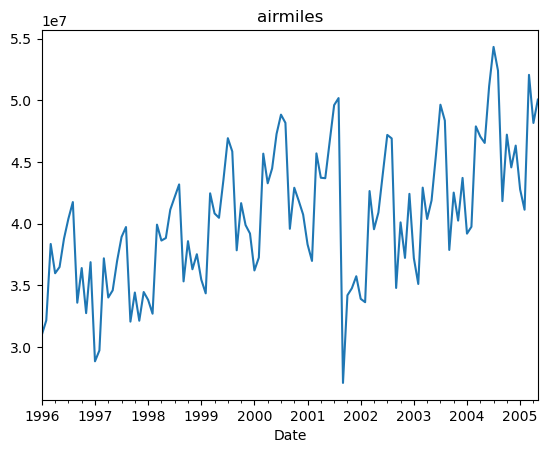

In [7]:
# Plot the monthly airmiles values
df['airmiles'].plot(title = 'airmiles')
plt.show()

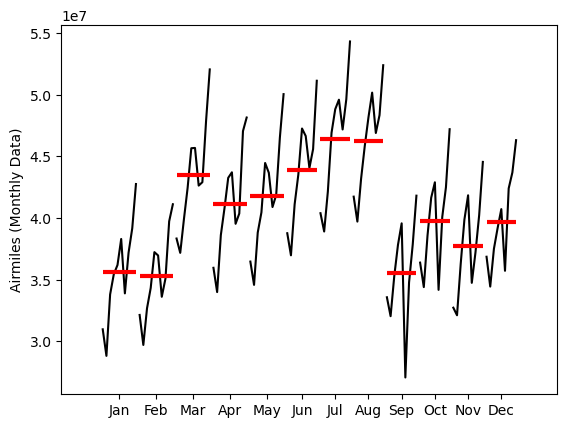

In [8]:
# month_plot(): A utility function to visualize seasonality in time series data.
# It shows the average value for each month across multiple years, highlighting seasonal patterns.
# Red lines: Indicate the mean value for each month, providing a reference for variability.

# Plotting the monthly seasonality of the 'airmiles' dataset
month_plot(df['airmiles'], ylabel='Airmiles (Monthly Data)')
plt.show()


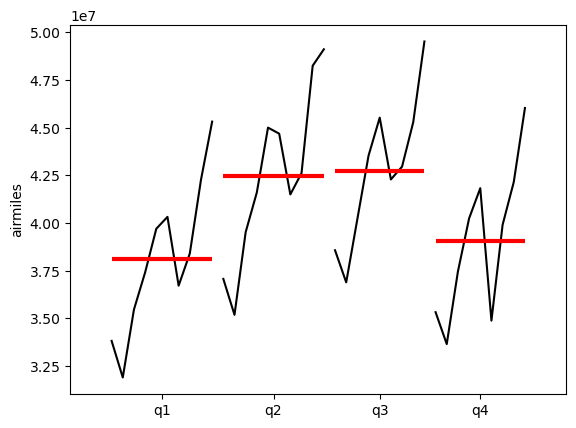

In [9]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of the complaint values
quarter_plot(df['airmiles'].resample('Q').mean(),
           ylabel = 'airmiles')
plt.show()

seasonal_decompose: A tool used to break down a time series into its key components, helping to uncover and analyze underlying patterns.
Components:
- Trend: Represents the overall long-term direction of the data (e.g., upward, downward, or stable).
- Seasonal: Captures repeating patterns or cycles occurring at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The random noise or unexplained variation left after removing the trend and seasonal components.

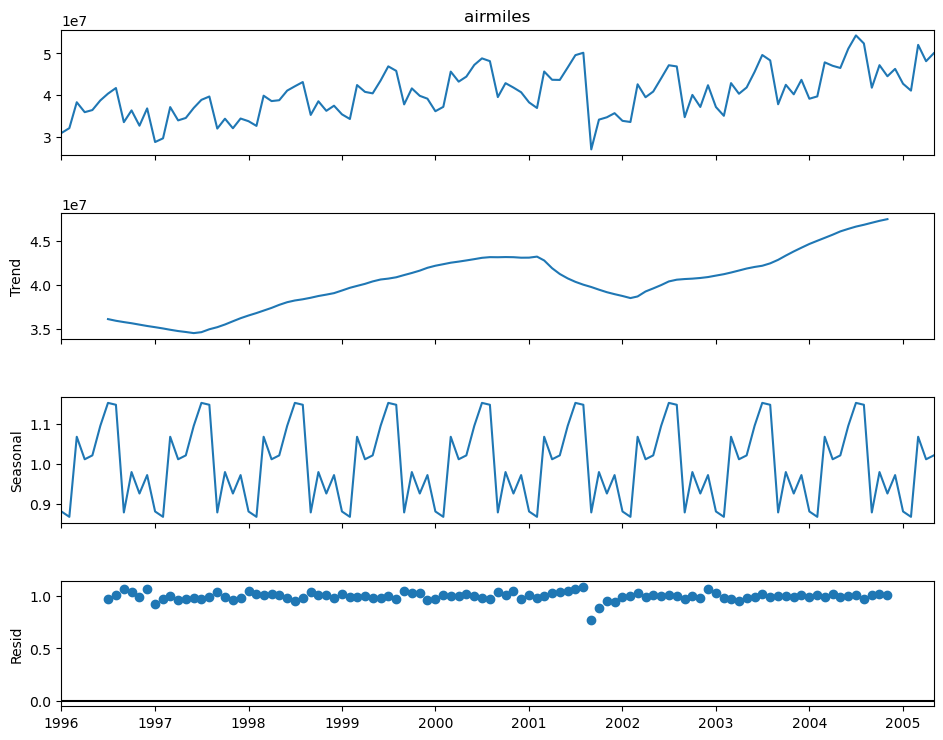

In [10]:
# Multiplicative model type, with yearly seasonality
decomposition = seasonal_decompose(df['airmiles'],
                                   model = 'mul',
                                   period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation: A statistical measure that quantifies the relationship between a time series and its lagged version, revealing repeating patterns or cycles.

Purpose:
To detect underlying structures, such as seasonality or trends, in a time series dataset.

Interpretation:
Range: Values range from -1 to 1.
- 1: Perfect positive correlation (high similarity between the series and its lagged version).
- -1: Perfect negative correlation (inverse relationship).
- 0: No correlation (random or uncorrelated behavior).

ACF (Autocorrelation Function) Plot:
- X-axis: Lag periods (time steps).
- Y-axis: Autocorrelation coefficient.

Key Features:
- Autocorrelation at lag 0 is always 1 (a series is fully correlated with itself).
Significant spikes at specific lags suggest cyclical patterns or periodicity.

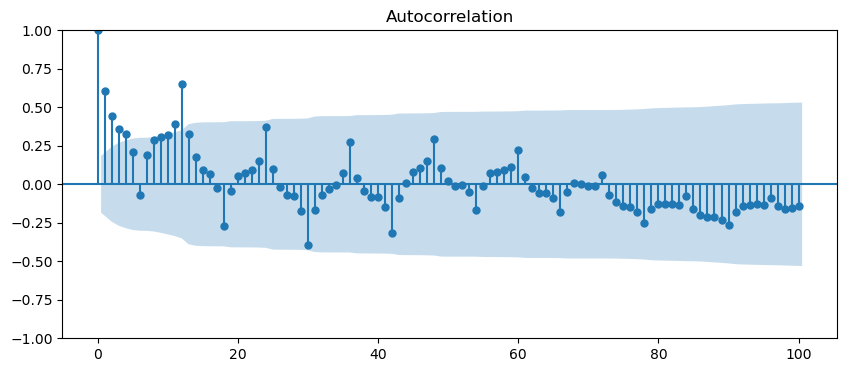

In [11]:
# Plot the autocorrelation (ACF) of airmiles values
fig, ax = plt.subplots(figsize = (10,4))
plot_acf(df['airmiles'], lags = 100, ax = ax)
plt.show()

Partial Autocorrelation Function (PACF): Measures the correlation between a time series and its lag, after accounting for the influence of all shorter lags.

Purpose:
To identify the direct relationship between an observation and its lag, isolating it from the effects of intermediate lags.
Difference Between ACF and PACF:

- ACF: Captures the total correlation at each lag, including both direct and indirect effects.
- PACF: Focuses only on the direct correlation at each lag, excluding indirect effects from shorter lags.

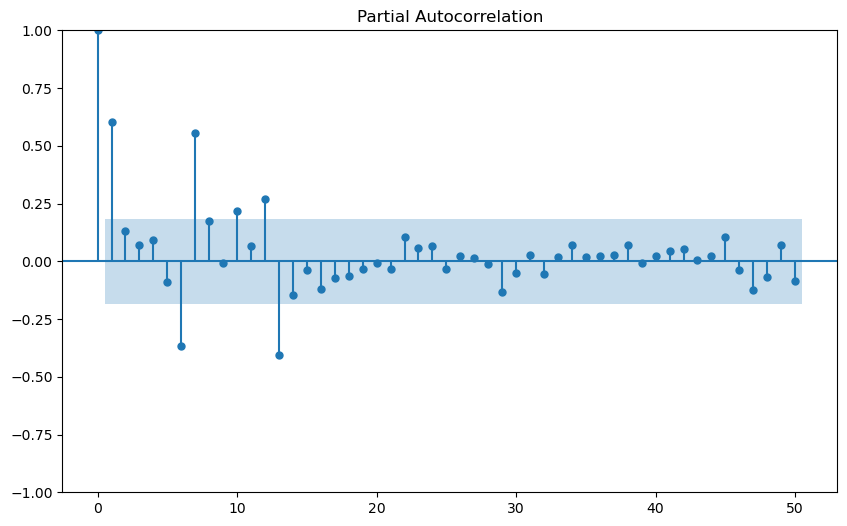

In [13]:
# Plot the partial autocorrelation (PACF) of airmiles values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['airmiles'], lags = 50, ax = ax)
plt.show()

:# Goal : to predict the next 12 months

In [15]:
# Training and Test Split
# Train: all data except last n periods of the column 'airmiles'
# Test: last n periods of the column 'airmiles'

periods = 12 # 1 year = 12 montha 
train, test = df.iloc[:-periods,0], df.iloc[-periods:, 0 ]

# Triple Exponential Smoothing (Holt-Winters method)

1- Seasonality Handling: Designed to accommodate time series data with seasonal patterns, whether daily, weekly, monthly, quarterly, or annual, making it ideal for data with periodic fluctuations.

2- Components:
- Level: The smoothed value representing the base value of the series.
- Trend: The long-term movement or direction of the series.
- Seasonal: The repeating pattern or cycle observed at regular intervals.

In [21]:
# Experiment with different combinations of trend and seasonality types ('add' or 'mul') 
# to minimize the forecasting error, which will be evaluated later.
model_triple = ExponentialSmoothing(train,
                                    trend='mul',
                                    seasonal='mul',
                                    seasonal_periods=12).fit()

/Users/adhamelkhouly/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [22]:
predictions_triple = model_triple.forecast(len(test))
predictions_triple

2004-06-01    4.989814e+07
2004-07-01    5.232020e+07
2004-08-01    5.246731e+07
2004-09-01    4.147231e+07
2004-10-01    4.632250e+07
2004-11-01    4.366543e+07
2004-12-01    4.583298e+07
2005-01-01    4.142760e+07
2005-02-01    4.104454e+07
2005-03-01    5.053423e+07
2005-04-01    4.798055e+07
2005-05-01    4.852405e+07
Freq: MS, dtype: float64

- `MAE` - the average of the absolute differences between predicted and actual values.
- `RMSE` - the square root of the average of squared differences between prediction and actual observation.
It gives a relatively high weight to large errors, making it sensitive to outliers.
- `MAPE` - the size of the error in percentage terms. the average of the absolute percent errors of forecasts, which helps to understand the accuracy in terms of percentage.

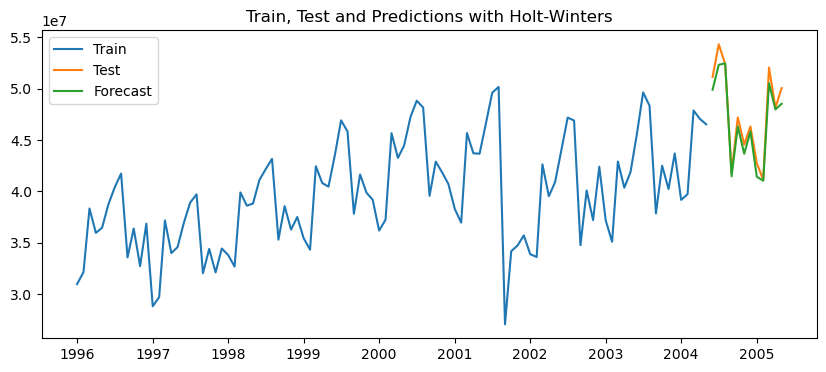

The MAE is 877575.16
The RMSE is 1075653.07
The MAPE is 1.80 %


In [24]:
def evaluate_model(train, test, predictions, chart_title):
    """
    Evaluates a time series model by visualizing forecasts and calculating error metrics.

    Args:
        train (pd.Series): Training data.
        test (pd.Series): Test data.
        predictions (pd.Series): Forecasted values.
        chart_title (str): Title for the plot.

    Returns:
        None
    """
    # Visualization
    plt.figure(figsize=(10, 4))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Forecast')
    plt.title(f"Train, Test, and Predictions: {chart_title}")
    plt.legend()
    plt.grid()
    plt.show()

    # Error metrics
    mae = mean_absolute_error(test, predictions)
    rmse = mean_squared_error(test, predictions, squared=False)
    mape = mean_absolute_percentage_error(test, predictions)

    print(f"The MAE is {mae:.2f}")
    print(f"The RMSE is {rmse:.2f}")
    print(f"The MAPE is {mape * 100:.2f}%")


# Call the model_assessment function with the specified arguments
evaluate_model(train, test, predictions_triple, "Holt-Winters")

## Summary
- The Holt-Winters model effectively captured the seasonal patterns in the airmiles dataset.
- Key Evaluation metric:
  - MAPE: **1.80%**
- The forecast aligns closely with the test data, suggesting the model is suitable for similar time series.
